# ML Workshop - Part 1: MNIST

### install packages

restart kernel afterwards to reload packages

In [1]:
pip install --quiet torch torchvision pytorch-lightning wandb matplotlib

Note: you may need to restart the kernel to use updated packages.


load pytorch and test if pip install worked

In [2]:
import torch

test if CUDA is available  
part1 works without a GPU, but training is slower.

In [3]:
torch.cuda.is_available()

True

### MNIST

download MNIST dataset

In [4]:
from torchvision.datasets import MNIST
MNIST(".", train=True, download=True)
MNIST(".", train=False, download=True)

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test

more about MNIST:
- http://yann.lecun.com/exdb/mnist/
- https://pytorch.org/vision/stable/datasets.html#mnist

set seed for random. so all runs have the same random!<br/>
https://pytorch-lightning.readthedocs.io/en/latest/starter/lightning_lite.html?#seed-everything

In [5]:
import pytorch_lightning as lightning
lightning.seed_everything(42)

Global seed set to 42


42

split MNIST into variables  
(split 60000 train into train/validation)  
(never use test data for validation!)

In [6]:
import torchvision
mnist_train= MNIST(".", train=True, transform=torchvision.transforms.ToTensor())
train_ds, validation_ds = torch.utils.data.random_split(mnist_train,[55000,5000])
#
test_ds = MNIST(".", train=False, transform=torchvision.transforms.ToTensor())

In [7]:
mnist_train.data.size()

torch.Size([60000, 28, 28])

In [8]:
len(train_ds), len(validation_ds)

(55000, 5000)

plot an image from test dataset

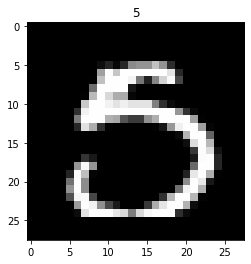

In [9]:
import random
import matplotlib.pyplot as plt
number = random.randint(0, 1000)
plt.imshow(test_ds.data[number], cmap='gray')
plt.title('%i' % test_ds.targets[number])
plt.show()

show first dataset as tensors

In [10]:
# test_ds[0][0]

class of first test dataset

In [11]:
test_ds.targets[0]

tensor(7)

### weights & biases

get your token here: https://wandb.ai/settings

In [12]:
import wandb
wandb.login()

wandb: Currently logged in as: mfa (use `wandb login --relogin` to force relogin)


True

### The model!

![](https://miro.medium.com/max/700/1*HWhBextdDSkxYvz0kEMTVg.png)<br/>
(image source: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627)

CrossEntropyLoss(x, y) := NLLLoss(LogSoftmax(x), y) -- https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [13]:
from torchmetrics import Accuracy
from torch.nn import functional as F

In [14]:
class MNISTModel(lightning.LightningModule):
    def __init__(self, hidden_size=10, learning_rate=1e-2):
        super().__init__()
        self.save_hyperparameters()

        self.learning_rate = learning_rate
        self.batch_size = 128

        # 10 different numers; images are 28x28 greyscale
        self.num_classes = 10
        channels, width, height = (1, 28, 28)

        # simple NN
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(channels * width * height, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, self.num_classes),
        )
        self.loss = torch.nn.CrossEntropyLoss()

        acc = Accuracy()
        self.train_acc = acc.clone()
        self.valid_acc = acc.clone()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log("train/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        self.log("train/acc", self.train_acc)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx, name="val"):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log(f"{name}/loss", loss)

        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc(preds, y)

        self.log(f"{name}/acc", self.valid_acc)
        return {"loss": loss}

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, name="test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_ds, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(validation_ds, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(test_ds, batch_size=self.batch_size)

links for questions:
- activation function: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
- optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

### train the model

In [15]:
model = MNISTModel()
wandb_logger = lightning.loggers.WandbLogger(project="ml-workshop-part1--MNIST")
wandb_logger.watch(model, log="all")
trainer = lightning.Trainer(max_epochs=3, logger=wandb_logger)
trainer.fit(model)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Sequential       | 8.0 K 
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | valid_acc | Accuracy         | 0     
-----------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [16]:
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at /home/mfa/machine-learning-workshop/ml-workshop-part1--MNIST/3dnutihg/checkpoints/epoch=2-step=1289.ckpt
Loaded model weights from checkpoint at /home/mfa/machine-learning-workshop/ml-workshop-part1--MNIST/3dnutihg/checkpoints/epoch=2-step=1289.ckpt
/home/mfa/.virtualenvs/machine-learning-workshop/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9261999726295471, 'test/loss': 0.2697216868400574}
--------------------------------------------------------------------------------


[{'test/loss': 0.2697216868400574, 'test/acc': 0.9261999726295471}]

finish wandb run. otherwise the next training is appended!

In [17]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆█
test/acc,▁
test/loss,▁
train/acc,▁▁▄▄▂▇▅▅▁▇▅▅▇▃▄▅▅▄▅▅█▃▅▇▇
train/loss,▆█▃▅▅▂▄▃▄▂▅▅▃▄▃▄▂▃▃▄▁▃▂▂▁
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
val/acc,▁██
val/loss,█▁▁
epoch,3
test/acc,0.9262
test/loss,0.26972


### show one test example classification

In [18]:
image_number = 23

In [19]:
test_ds.targets[image_number]

tensor(5)

the image needs to become a one element batch

In [20]:
one_dataset = test_ds[image_number][0].reshape(1, 1, 28, 28)

In [21]:
one_dataset.size()

torch.Size([1, 1, 28, 28])

In [22]:
trainer.model(one_dataset)

tensor([[ -1.4970,  -8.2735,  -5.4512,   1.2322,   0.2442,   8.0919,   3.2754,
         -11.2216,   4.1386,  -4.7485]], grad_fn=<AddmmBackward0>)

In [23]:
torch.argmax(trainer.model(one_dataset), dim=1)

tensor([5])

target is **5** and the model says **5**

### try an image we created ourselves

example image: https://paste.madflex.de/eXYuvXsh/+inline 
the image should be 28 x 28, 1-bit colormap

<PIL.Image.Image image mode=L size=28x28 at 0x7F3925149E20>


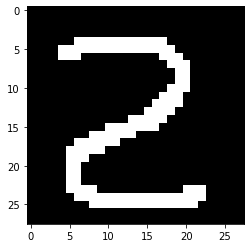

In [24]:
from PIL import Image
img = Image.open("own.png").convert('L')
print(img)
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

In [25]:
_img = torchvision.transforms.ToTensor()(img).reshape(1, 1, 28, 28)
trainer.model(_img)

tensor([[  2.8396, -18.5169,   8.4462,  12.3144, -18.3694,   1.9464, -16.8552,
           0.7772,  12.1373,   4.3318]], grad_fn=<AddmmBackward0>)

In [26]:
torch.argmax(trainer.model(_img))

tensor(3)

the model is not good enough

### (possible) steps to improve model

1) increase ``hidden_size``  (i.e. to 64)

2) add more layer(s) and/or dropout to model:

```
        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(channels * width * height, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size, self.num_classes),
        )
```

3) use CNNs (spoiler for workshop part 2)

```
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 7 * 7, self.num_classes),
        )
```

4) add color normalisation when loading MNIST (may or may not help - is in a lot of MNIST tutorials)
```
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                (0.1307,), (0.3081,))
        ])
```